<a href="https://colab.research.google.com/github/MominaSiddiq/AI_Generated_vs_HumanCreated_Sketches/blob/main/AI_vs_Human_sketches_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import collections
import tensorflow as tf
import matplotlib.pyplot as plt



# Fetch data
Fetching data from the drive in three folders (Splited Data): Test, Valid and Train  

In [ ]:
# Fetch dataset from the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Fetch the split data from the drive

train_dir = '/content/drive/MyDrive/sketch_classification_project/train'
valid_dir = '/content/drive/MyDrive/sketch_classification_project/valid'
test_dir = '/content/drive/MyDrive/sketch_classification_project/test'

# Data Augmentation

Doing the augmentation of the training data by rotating, rescaling, fliping, and shifting width and height.



In [ ]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Randomly shear images
    zoom_range=0.2,         # Randomly zoom into images
    horizontal_flip=True    # Randomly flip images horizontally
)

# No augmentation for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='binary'      # Binary classification: AI vs Human
)

# Load validation data without augmentation
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Load test data without augmentation
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 11774 images belonging to 2 classes.
Found 1120 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


# Pre-processing
Pre-processing of this images data include:


*   Re-sizing of images for efficient training.

*   Setting the batch size to 32 optimizes memory usage and speeds up training.



In [ ]:
# Load training data
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/sketch_classification_project/train',
    target_size=(128, 128),  # Resize images to 128x128
    batch_size=32,
    class_mode='binary',  # Binary classification: AI vs Human
)

# Load validation data
valid_data = valid_datagen.flow_from_directory(
    '/content/drive/MyDrive/sketch_classification_project/valid',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
)

# Load test data
test_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/sketch_classification_project/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
)

Found 11774 images belonging to 2 classes.
Found 1120 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [ ]:
train_data.class_indices  # Displays class labels (e.g., {'AI': 0, 'Human': 1})

# Print class distribution

counter = collections.Counter(train_data.classes)
print("Training set class distribution:", counter)

counter_val = collections.Counter(valid_data.classes)
print("Validation set class distribution:", counter_val)

counter_test = collections.Counter(test_data.classes)
print("Test set class distribution:", counter_test)

Training set class distribution: Counter({0: 5894, 1: 5880})
Validation set class distribution: Counter({0: 560, 1: 560})
Test set class distribution: Counter({0: 280, 1: 280})


# Defining & Compiling CNN Model
Define and compile a basic CNN model for binary classification

1. Tried it by adding a dropout layer of 0.25.

In [ ]:
# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),  # Dropout to reduce overfitting

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout before the final dense layer

    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training CNN Model
Train the model on the training data and validate on the validation set.

In [ ]:
# Train the model
history = model.fit(
    train_data,           # Training data
    epochs=10,            # Number of passes over the entire training dataset
    validation_data=valid_data  # Validation data for monitoring performance
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 89/368 ━━━━━━━━━━━━━━━━━━━━ 1:27 314ms/step - accuracy: 0.5078 - loss: 0.7651

# Visualizing
To monitor the model's performance over time, plot the training and validation accuracy and loss.

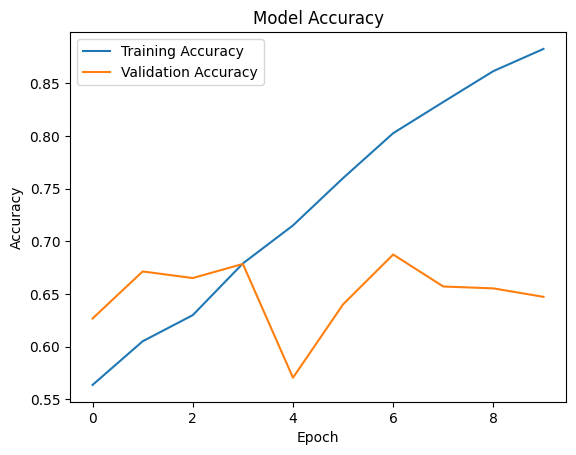

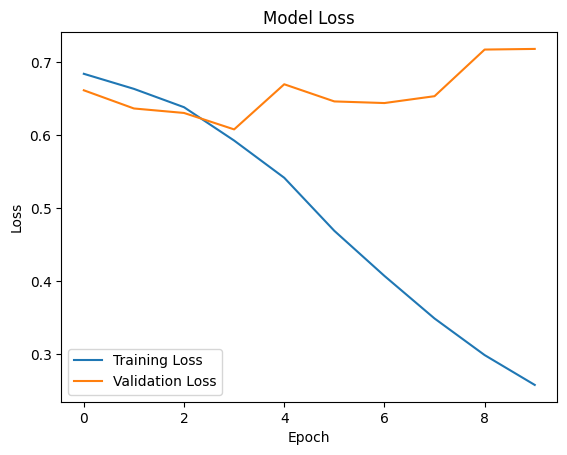

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()